## Analyising real data
Data from [Receding ice drove parallel expansions in Southern Ocean penguins](https://www.pnas.org/content/pnas/116/52/26690.full.pdf). They deposited the fastsimcoal formatted SFS files for each of the 10 penguin species in [figshare](https://figshare.com/collections/SNP_data_from_Receding_ice_drove_parallel_expansions_in_Southern_Ocean_penguins_/4475300)


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext rpy2.ipython

import datetime
import glob
import ipyparallel as ipp
import matplotlib.pyplot as plt
import momi
import numpy as np
import os
import pandas as pd
import time
import dadi
import warnings

from IPython.display import display

import PTA

### Convert fsc2 format to dadi
Project all samples down to the min sample size (pta only allows for one sample size across all pops)

I downloaded the fsc2 formatted files and put them in a directory `sfs`. momi.sfs_from_dadi() expects dadi format which is slightly different than fsc2. Essentially it looks like this:

```
1 observation
d0_0    d0_1    d0_2    d0_3    d0_4    d0_5    d0_6    d0_7    d0_8    d0_9    d0_10   d0_11   d0_12   d0_13   d0_14   d0_15   d0_16
0 1516 667 533 436 441 427 410 224 0 0 0 0 0 0 0 0
```
But it's supposed to look like this:
```
17 folded "Northern_rockhopper"
0 1516 667 533 436 441 427 410 224 0 0 0 0 0 0 0 0
1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
```

In [2]:
sfs_list = []
for f in glob.glob("sfs/*.obs"):
    # Parse the species name
    species = f.split("/")[-1].split(".")[0]
    with open(f) as infile:
        outfile = "sfs/{}.dadi.sfs".format(species)
        dat = infile.readlines()[2]
        nsamps = len(dat.split(" "))
        print("{} {}".format(f, nsamps))

        fs = dadi.Spectrum([float(x) for x in dat.split(" ")], pop_ids=[species])
        folded = fs.fold()
        # Project down to 16 haploid samples here because I know this is the size of the
        # smallest species
        proj = folded.project([16])
        proj.to_file(outfile)
        sfs = momi.sfs_from_dadi(outfile)
        sfs_list.append(sfs)

sfs/Macaroni_royal.obs 239
sfs/Emperor.obs 201
sfs/Northern_rockhopper.obs 17
sfs/Adelie.obs 157
sfs/Chinstrap.obs 83
sfs/King.obs 123
sfs/Gentoo.obs 71
sfs/Western_rockhopper.obs 51
sfs/Fiordland_crested.obs 41
sfs/Eastern_rockhopper.obs 137


## Construct the mSFS
Now that we have all the individual momi sfs objects we can call `PTA.msfs.multiSFS()` to construct the mSFS. There are two options here:

`proportions` - If False then sfs bins will be counts, if True the bins will be normalized to sum to 1.

`sort` - If True the bins will be sorted from greatest to least within each sfs config, if False no sorting.

In [3]:
sfs = sfs_list[0]
msfs = PTA.msfs.multiSFS(sfs_list, proportions=True, sort=True)
display(msfs.df)
sfs.dump("wat.txt")
msfs.to_dataframe()

,pop0,pop1,pop2,pop3,pop4,pop5,pop6,pop7,pop8,pop9
[[15__1]],0.543469,0.513573,0.489874,0.477760,0.475706,0.390427,0.368436,0.325741,0.323677,0.296388
[[14__2]],0.218906,0.196946,0.194208,0.193892,0.191576,0.186918,0.182904,0.170455,0.152947,0.143318
[[13__3]],0.133171,0.122377,0.118884,0.118311,0.114525,0.113256,0.112624,0.100418,0.099359,0.095697
[[12__4]],0.105893,0.101234,0.096229,0.093683,0.085590,0.075107,0.068336,0.066967,0.064655,0.058439
[[11__5]],0.094757,0.091170,0.089333,0.079264,0.068924,0.054371,0.053853,0.046045,0.043531,0.040231
[[10__6]],0.091749,0.086190,0.079934,0.068816,0.060032,0.047436,0.041099,0.035220,0.031090,0.030512
[[9_7]],0.088096,0.084118,0.075360,0.063472,0.055654,0.044193,0.034104,0.029382,0.025491,0.024883
[[8_8]],0.048131,0.041780,0.037018,0.030951,0.027170,0.021626,0.015931,0.013762,0.011952,0.011492


,pop0-[[15__1]],pop0-[[14__2]],pop0-[[13__3]],pop0-[[12__4]],pop0-[[11__5]],pop0-[[10__6]],pop0-[[9_7]],pop0-[[8_8]],pop1-[[15__1]],pop1-[[14__2]],...,pop8-[[9_7]],pop8-[[8_8]],pop9-[[15__1]],pop9-[[14__2]],pop9-[[13__3]],pop9-[[12__4]],pop9-[[11__5]],pop9-[[10__6]],pop9-[[9_7]],pop9-[[8_8]]
0,0.543469,0.218906,0.133171,0.105893,0.094757,0.091749,0.088096,0.048131,0.513573,0.196946,...,0.025491,0.011952,0.296388,0.143318,0.095697,0.058439,0.040231,0.030512,0.024883,0.011492


## Attach to the clustering backend

In [4]:
# ipcluster start --n=4 --cluster-id="PTA" --daemonize
ipyclient = ipp.Client(cluster_id="ipyrad")
len(ipyclient)

40

## Set parameters for the simluations

In [9]:
model = PTA.DemographicModel("unsorted-penguins")
## model parameters
model.set_param(param="nsamps", value = 16)
model.set_param(param="N_e", value = 200000)
model.set_param(param="tau", value = (1000,10000))
model.set_param(param="length", value = 1000)
model.set_param(param="num_replicates", value = 2000)
model.set_param(param="epsilon", value=(1.5, 10))
model.set_param(param="muts_per_gen", value=2.6e-7)

model._hackersonly["sorted_sfs"] = False
model._hackersonly["proportional_msfs"] = True
model.write_params(outdir="./", force=True)
print(model.get_params())

------- PTA params file (v.0.0.11)----------------------------------------------
unsorted-penguins    ## [0] [simulation_name]: The name of this simulation scenario
./default_PTA        ## [1] [project_dir]: Where to save files
10                   ## [2] [npops]: Number of populations undergoing co-demographic processes
16                   ## [3] [nsamps]: Numbers of samples for each populations
200000               ## [4] [N_e]: Effective population size of the contemporary population
1000-10000           ## [5] [tau]: Time of demographic change
1.5-10.0             ## [6] [epsilon]: Magnitude of demographic change
0                    ## [7] [zeta]: Proportion of coexpanding taxa. Default will sample U~(0, 1)
1000                 ## [8] [length]: Length in bp of each independent genomic region to simulate
2000,2000,2000,2000,2000,2000,2000,2000,2000,2000 ## [9] [num_replicates]: Number of genomic regions to simulate
1e-09                ## [10] [recoms_per_gen]: Recombination rate 

In [ ]:
model.simulate(nsims = 100, quiet=False, verbose=True, ipyclient=ipyclient)

    Generating 100 simulation(s).
  [###########         ]  56%  Performing Simulations    | 6:07:01 | 

## Construct the RF Regressor and predict using parameters of the empirical data

In [144]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    rgr = PTA.inference.Regressor(empirical_df=msfs.to_dataframe(), sims="default_PTA/all-SIMOUT.csv")
    est = rgr.predict(select_features=False, param_search=False, quick=False, verbose=True)

Predict() started: 2020-05-07 04:16:27.091124
Predict() finished: 2020-05-07 04:21:48.853001
Calculating prediction interval(s)


## Print estimated parameters and 95% prediction intervals

In [145]:
est

,zeta,zeta_e,psi,t_s,omega,taus_mean,taus_std,taus_skewness,taus_kurtosis,taus_median,taus_iqr,epsilons_mean,epsilons_std,epsilons_skewness,epsilons_kurtosis,epsilons_median,epsilons_iqr
estimate,0.498,5.3,0.4,16011.3,2.6639,7733.3129,2477.723100,0.7843,-0.0631,4765.65,6536.05,7.0948,0.0,0.0003,-2.828,8.0921,0.0
lower 0.025,0.081,2.0,0.0,9286.0,0.0000,1783.5000,1701.837036,0.0000,-2.0000,1305.00,1378.25,2.0000,0.0,-0.6330,-3.000,2.0000,0.0
upper 0.975,0.946,10.0,1.0,44781.0,13.3060,26144.5000,3160.873047,1.4000,1.8620,9208.50,25949.25,10.0000,0.0,0.6360,-1.280,10.0000,0.0


## Evaluate feature importances for each parameter

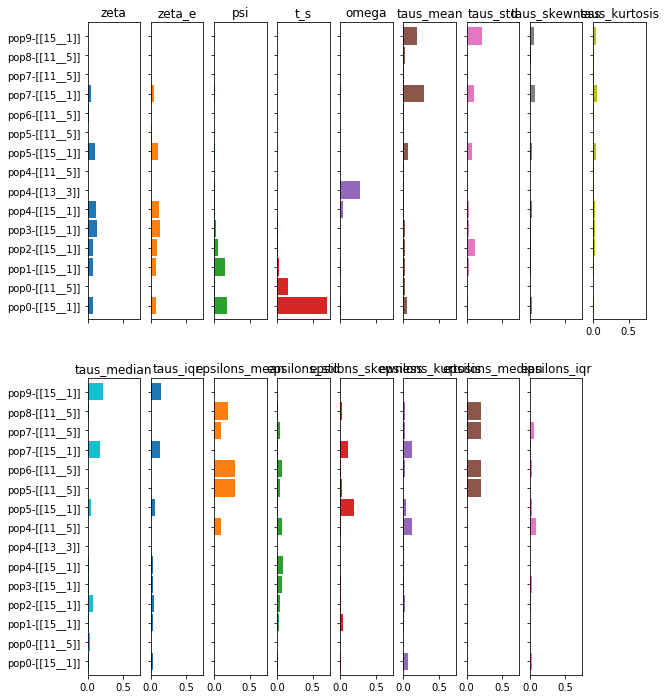

In [141]:
_ = rgr.plot_feature_importance(cutoff=0.11)

In [120]:
pd.read_csv("default_PTA/penguins-SIMOUT.csv", sep=" ").tail()

,zeta,zeta_e,psi,t_s,omega,taus_mean,taus_std,taus_skewness,taus_kurtosis,taus_median,...,pop9-[[_3_13]],pop9-[[_4_12]],pop9-[[12__4]],pop9-[[_5_11]],pop9-[[11__5]],pop9-[[10__6]],pop9-[[_6_10]],pop9-[[9_7]],pop9-[[7_9]],pop9-[[8_8]]
20105,0.549,5,1,2390,0.001,4600.333,2110.742,1.292,0.435,4137.0,...,0.020,0.019,0.060,0.019,0.047,0.041,0.021,0.033,0.027,0.028
20106,0.455,5,1,4677,0.001,5089.833,1925.264,0.556,-0.327,4941.5,...,0.018,0.024,0.062,0.021,0.048,0.040,0.026,0.032,0.027,0.029
20107,0.022,0,0,2063,0.001,5339.000,2882.068,-0.055,-1.487,5645.0,...,0.022,0.025,0.067,0.024,0.058,0.047,0.025,0.045,0.035,0.038
20108,0.606,6,1,7841,0.001,4116.600,2824.667,0.393,-1.791,2284.0,...,0.023,0.023,0.071,0.021,0.056,0.051,0.031,0.036,0.028,0.033
20109,0.069,1,0,4789,0.001,4939.500,2452.969,0.375,-1.117,4500.5,...,0.023,0.023,0.071,0.025,0.053,0.050,0.028,0.042,0.033,0.029
